In [8]:
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
import pandas as pd
import numpy as np

SEED = 42
np.random.seed(SEED)
scaler = MinMaxScaler()
EMPRESA = 'EGIE3.SA'

In [9]:
def perform_linear_regression(X_train, y_train, X_test, y_test):
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    pred = lr.predict(X_test)
    cd_lr = r2_score(y_test, pred)
    return (lr, cd_lr)

In [10]:
def perform_neural_network(X_train, y_train, X_test, y_test):
    rn = MLPRegressor()
    parameter_space = {
            'hidden_layer_sizes': [(i,) for i in list(range(1, 21))],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam', 'lbfgs'], 
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant', 'adaptive'],
        }

    search = GridSearchCV(rn, parameter_space, n_jobs=-1, cv=5)

    search.fit(X_train, y_train)
    clf = search.best_estimator_
    cd_nn = search.score(X_test, y_test)
    return (clf, cd_nn)

In [11]:
def tratar_dados(df):
    # Adicionando Médias Moveis de 5 e 21 dias
    df['mm5d'] = df['Close'].rolling(5).mean()
    df['mm21d'] = df['Close'].rolling(21).mean()
    df['Close'] = df['Close'].shift(-1)

    df.drop(columns=['Dividends','Stock Splits'], inplace=True)
    df.dropna(inplace=True)

    X = scaler.fit_transform(df.drop(columns=['Close']))
    y = df['Close']
    return df, X, y

In [12]:
def get_dados_empresa(empresa):
    dados_empresa = yf.Ticker(empresa).history(period='max')
    return tratar_dados(dados_empresa)

In [13]:
def split_treino_teste(X, y, qtd_validacao=0):
    qtd_linhas = len(X)
    qtd_linhas_treino = round(.75 * qtd_linhas)
    qtd_linhas_teste = qtd_linhas - qtd_validacao

    X_train = X[:qtd_linhas_treino]
    y_train = y[:qtd_linhas_treino]

    X_test = X[qtd_linhas_treino:qtd_linhas_teste]
    y_test = y[qtd_linhas_treino:qtd_linhas_teste]

    X_valid = X[qtd_linhas_teste:]
    y_valid = y[qtd_linhas_teste:]

    return (X_train, y_train, X_test, y_test, X_valid, y_valid)

In [14]:
def split_dados_empresa(empresa, qtd_validacao=0):
    dados, X, y = get_dados_empresa(empresa)
    X_train, y_train, X_test, y_test, X_valid, y_valid = split_treino_teste(X, y, qtd_validacao=qtd_validacao)
    return dados, X_train, y_train, X_test, y_test, X_valid, y_valid

In [15]:
def criar_treinar_modelo(empresa = None, X_train = None, y_train = None, X_test = None, y_test = None, X_valid = None, y_valid = None, modelo = None):
    if (X_train == None or y_train == None or X_test == None or y_test == None or X_valid == None or y_valid == None) and empresa == None:
        raise Exception("Deve-se passar algum parâmetro")
    
    if empresa != None:
        (_, X_train, y_train, X_test, y_test, X_valid, y_valid) = split_dados_empresa(empresa)

    (lr, cd_lr) = perform_linear_regression(X_train, y_train, X_test, y_test)
    (nn, cd_nn) = perform_neural_network(X_train, y_train, X_test, y_test)
    
    return lr if cd_lr >= cd_nn else nn
 

In [16]:
def prever_proximo_dia(modelo, empresa):
    dados = yf.Ticker(empresa).history(period='max')
    dados, X, y = tratar_dados(dados)
    dados = pd.DataFrame(X).tail(1)
    return modelo.predict(dados)    

In [71]:
(dados, X_train, y_train, X_test, y_test, X_valid, y_valid) = split_dados_empresa(EMPRESA,qtd_validacao=15)
modelo = criar_treinar_modelo(EMPRESA)
prever_proximo_dia(modelo, EMPRESA)

array([46.21699075])

In [75]:
y_pred = modelo.predict(X_valid)
# y_valid

datas = list(y_valid.index)
y_valid.reset_index(drop=True, inplace=True)

colunas = {
    'data': datas,
    'real': y_valid,
    'predicao': y_pred
}

plt.plot(colunas['data'], colunas['real'].shift(1), marker='o', label='real')
plt.plot(colunas['data'], colunas['predicao'], marker='o', label='predicao')
plt.legend()

0     44.450001
1     44.340000
2     45.119999
3     45.369999
4     45.250000
5     45.610001
6     45.770000
7     45.779999
8     45.959999
9     46.610001
10    46.349998
11    46.450001
12    46.529999
13    46.070000
14    45.599998
Name: Close, dtype: float64

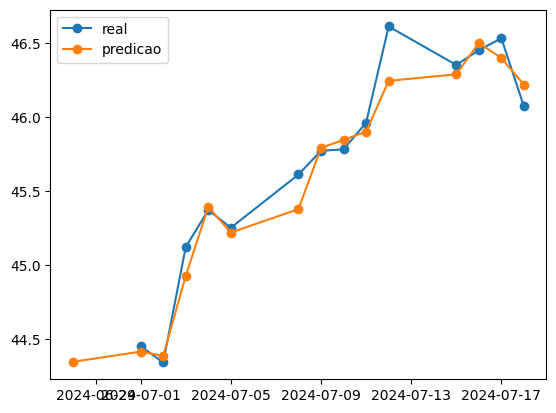

In [18]:
prever_proximo_dia(modelo, EMPRESA)

array([46.21699075])